In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
warnings.resetwarnings()

# COVID-19 prediction using a fully connected neural network 
<a id='toc'></a>

## Table of contents

## [1. Introduction](#intro)
## [2. Data](#data)
## [3. Ridge Regression](#model)
## [4. Analysis](#analysis)
## [5. Conclusion and Future Work](#conclusion)

# 1. Introduction

This notebook explores the viability of a fully connected neural network for the prediction of future COVID-19 cases (per million people). The architecture of the neural network is held constant in this notebook, but the possibilities are endless. Some other architectures were tried but they are left out of this notebook so that it is easier to follow.

In [2]:
############### Helper functions in case of debugging/data introspection############
def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    # Iterate over the dates and create the frames of width frame_size.
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]

        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)

        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        # The frames 
        if max_date_in_window == start_date:
            print('Starting with frame spanning the time_index values:', 
                  max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame spanning the time_index values:',
          max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices

def flatten_Xy(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict, n_countries, title='',suptitle='',figname=None, scale=None, s=None):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    mse_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_naive, r2_predict))

    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    
    ax1.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_naive,3)),fontsize=14)
    ax1.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_naive,3)),fontsize=14)
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')
             
    ax2.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_predict,3)),fontsize=14)
    ax2.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_predict,3)),fontsize=14)
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)

    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    ax3.set_title('')
    ax4.set_title('')
    ax3.set_ylabel('Residual')
    ax4.set_ylabel('Residual')
    ax3.grid(True)
    ax4.grid(True)
    
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
        
    plt.show()
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

# 2. Data processing
<a id='data'></a>
[Return to table of contents](#toc)

The data processing is the same as the prototyping notebook, ```COVID19_model_prototypes.ipynb```. The reader is directed there for more detail.

In [3]:
data = pd.read_csv('model_data.csv', index_col=0)

#### Feature selection

In regards to the feature data being considered, I am using the time series corresponding to new cases per million, its logarithm, the OxCGRT "government response index" which scores each goverments reaction with a number from 0 to 100. 
There are some features which at first seem relevant but I am not using due to the fact that they are time-delayed with respect to new cases, for example, deaths and recoveries of course occur a case is confirmed by definition. I am in fact not using the data on the number of tests either because the feature lacks a consistent set of units; this would mean that the feature would need to be split into multiple features, one for each unit. 

In [4]:
modeling_features = ['new_cases_per_million', 'government_response_index', 'log_new_cases_per_million']
model_data = data.copy().loc[:, modeling_features]
new_cases_index = 0

# convenience paramters
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

# time frame related parameters
frame_size = 28
start_date = frame_size + data.time_index.min()

# size of splits, forecasting interval
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

#### Time frame creation 

In [5]:
# Create splits into predictors and dependent variable. 
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)

Starting with frame spanning the time_index values: 0 27
Ending with frame spanning the time_index values: 154 181


#### Train, validate, test splits of the data

In [6]:
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

# rescale the data to [0,1] by using a fictitious maximum as 1.
scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_nn_train, y_nn_train, X_nn_validate, y_nn_validate, X_nn_test, y_nn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

In [7]:
print('The shape of the original (before being flattened tensor is', X.shape)
print('There are a total of {} frames'.format(X.shape[0]))
print('There are a total of {} countries'.format(X.shape[1]))
print('There are a total of {} time steps in each frame'.format(X.shape[2]))
print('There are a total of {} features'.format(X.shape[3]))

The shape of the original (before being flattened tensor is (155, 146, 28, 3)
There are a total of 155 frames
There are a total of 146 countries
There are a total of 28 time steps in each frame
There are a total of 3 features


Flatten the splits to be compatible for Keras.

In [8]:
flat_splits = flatten_Xy(scaled_splits)
(X_nn_train_model,y_nn_train_model,X_nn_validate_model,
 y_nn_validate_model,X_nn_test_model,y_nn_test_model) = flat_splits

Select the correct values for the naive baseline.

In [9]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

# 3. Neural network model cross validation
<a id='model'></a>
[Return to table of contents](#toc)

The specific architecture will consist of two fully connected layers, follow by a ReLU activation layer. ReLU is used because the final prediction should be non-negative in order to be sensible. The input of the neural network is as follows:
first, select the features with which to model. Then, compose "time-frames" consisting of 28 days of these features and pass them to the fully connected neural network. The data formatting and setup is the same as in the notebook ```COVID19_model_prototypes.ipynb```, I direct the reader there for a more thorough explanation.

Create the combinations of hyperparameters to search for the best combination. Note that when this is a high dimensional test, the cross-validation is over single seeds.

In [10]:
epochs_list = [50, 75, 100, 125, 150]
batch_size_list = [1024]
first_layer_output_dimension_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
parameter_combinations = list(itertools.product(epochs_list, batch_size_list, first_layer_output_dimension_list))

So that redundant, time consuming calculations are not performed every notebook run, create a crude
logging system such that the model is only fit with a certain set of parameters if hasn't been done in the past, as
indicated by the presence of a score in the csv file.

In [11]:
save_filename = 'nn_score_logging.csv'
new_score_df = pd.DataFrame(np.array(parameter_combinations), 
                                columns=['epochs','batch_size',
                                         'first_dense_layer_output_dimension'])
new_score_df.loc[:, 'mean_squared_error'] = np.nan
new_score_df.loc[:, 'mean_absolute_error'] = np.nan
new_score_df.loc[:, 'explained_variance'] = np.nan
new_score_df.loc[:, 'naive_mean_absolute_error'] = np.nan
new_score_df.loc[:, 'naive_explained_variance'] = np.nan
new_score_df.loc[:, 'naive_mean_squared_error'] = np.nan
    
if os.path.isfile(save_filename):
    all_scores = pd.concat((pd.read_csv(save_filename,
                                        index_col=0), new_score_df),axis=0).reset_index(drop=True)
else:
    all_scores = new_score_df.reset_index(drop=True)

# remove any duplicate parameter combinations, as the same seeds are being used. 
no_duplicates_index = all_scores.iloc[:, :3].drop_duplicates().index
all_scores = all_scores.loc[no_duplicates_index,:]

Iterate over the parameter combinations; note that I believe that the number of parameters should be fewer in number than the number of samples. Perform cross-validation not by using folds of the data but rather different seeds for the weights. Splitting the data is unwise because it would select parameters based on historical rather than present day values.

In [12]:
zero_seeds = [0,1,2]
one_seeds = [3,4,5]

In [13]:
for i in all_scores[all_scores.mean_squared_error.isna()].index:

    hyperparameters = all_scores.loc[i, :].iloc[:3].astype(int).values
    (epochs, batch_size, first_layer_output_dimension) = hyperparameters
    
    
    mse_list = []
    naive_mse_list = []
    explained_variance_list = []
    naive_explained_variance_list = []
    mae_list = []
    naive_mae_list = []
    
    for j in range(len(zero_seeds)):
        nn_input = Input(shape=(np.prod(X_nn_train.shape[2:]),))
        flat = Flatten()(nn_input)
        dense0 = Dense(int(first_layer_output_dimension), 
                        use_bias=False,
                       kernel_initializer=RandomNormal(seed=zero_seeds[j]),
                       )(flat)
        dense1 = Dense(1, 
                        activation='relu',
                        use_bias=False,
                       kernel_initializer=RandomNormal(seed=one_seeds[j]),
                       )(dense0)

        nn = Model(inputs=nn_input, outputs=dense1)
        nn.compile(loss='mse', optimizer=Adam())
        history = nn.fit(X_nn_train_model, y_nn_train_model, epochs=epochs, validation_data=(X_nn_validate_model, y_nn_validate_model), 
                  batch_size=batch_size, verbose=0)

        y_true = y_nn_validate_model.ravel()
        y_predict = nn.predict(X_nn_validate_model).ravel()
        y_naive = y_validate_naive.ravel()

        # mean squared errors
        naive_mse_list.append(mean_squared_error(y_true.ravel(), y_naive.ravel()))
        mse_list.append(mean_squared_error(y_true.ravel(), y_predict))
        # explained variance
        naive_explained_variance_list.append(explained_variance_score(y_true.ravel(), y_naive.ravel()))
        explained_variance_list.append(explained_variance_score(y_true.ravel(), y_predict))
        # mean absolute error
        mae_list.append(mean_absolute_error(y_true.ravel(), y_predict))
        naive_mae_list.append(mean_absolute_error(y_true.ravel(), y_naive.ravel()))

    # add the scores
    all_scores.loc[i,'naive_mean_squared_error'] =  np.mean(naive_mse_list)
    all_scores.loc[i,'mean_squared_error']  = np.mean(mse_list)
    all_scores.loc[i,'naive_explained_variance']  = np.mean(naive_explained_variance_list)
    all_scores.loc[i,'explained_variance']  = np.mean(explained_variance_list)
    all_scores.loc[i,'naive_mean_absolute_error']  =np.mean(naive_mae_list)
    all_scores.loc[i,'mean_absolute_error']  = np.mean(mae_list)
    # every time a new score is calculated, overwrite the original file to log scoring.
    all_scores.to_csv(save_filename)

    print('#',end='')
    if (i % 50 == 0) & i>0:
          print('{} runs completed'.format(str(i)))

Look at the parameters and top ten (smallest) mean squared error scores.

In [14]:
all_scores.sort_values(by='mean_squared_error').head(10)

,epochs,batch_size,first_dense_layer_output_dimension,mean_squared_error,mean_absolute_error,explained_variance,naive_mean_absolute_error,naive_explained_variance,naive_mean_squared_error
54,400,1024,256,182.385480,5.974426,0.939019,5.934804,0.926058,219.307632
104,150,1024,1024,189.002198,6.567587,0.936845,5.934804,0.926058,219.307632
53,400,1024,128,189.189832,6.234090,0.936545,5.934804,0.926058,219.307632
42,200,1024,128,191.509850,6.756534,0.935516,5.934804,0.926058,219.307632
83,100,1024,512,192.351979,6.934692,0.935186,5.934804,0.926058,219.307632
102,150,1024,256,192.384777,6.919804,0.935476,5.934804,0.926058,219.307632
51,400,1024,32,192.906641,6.613071,0.935458,5.934804,0.926058,219.307632
74,75,1024,1024,193.492947,6.707488,0.934975,5.934804,0.926058,219.307632
50,400,1024,24,194.239142,6.847959,0.934630,5.934804,0.926058,219.307632
103,150,1024,512,195.504490,6.868211,0.934306,5.934804,0.926058,219.307632


In [15]:
all_scores.loc[all_scores.mean_squared_error.idxmin(),:]

epochs                                 400.000000
batch_size                            1024.000000
first_dense_layer_output_dimension     256.000000
mean_squared_error                     182.385480
mean_absolute_error                      5.974426
explained_variance                       0.939019
naive_mean_absolute_error                5.934804
naive_explained_variance                 0.926058
naive_mean_squared_error               219.307632
Name: 54, dtype: float64

Unfortunately this does not beat the naive baseline (the scores are with respect to the validation set).

In [16]:
best_model_parameters = all_scores.loc[all_scores.mean_squared_error.idxmin(),:].iloc[:3]
print(best_model_parameters)

epochs                                 400.0
batch_size                            1024.0
first_dense_layer_output_dimension     256.0
Name: 54, dtype: float64


Try again with a different seed, see if all hope is lost.

In [17]:
X_final_train = np.concatenate((X_nn_train_model, X_nn_validate_model),axis=0)
y_final_train = np.concatenate((y_nn_train_model, y_nn_validate_model),axis=0)

In [18]:
kernel_final_0 = RandomNormal(seed=8)
kernel_final_1 = RandomNormal(seed=42)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train the model one last time using the cross validated parameters.

In [19]:
(epochs, batch_size, first_layer_output_dimension) = best_model_parameters
nn_input = Input(shape=(np.prod(X_nn_train.shape[2:]),))
flat = Flatten()(nn_input)
dense0 = Dense(first_layer_output_dimension, 
                use_bias=False,
               kernel_initializer=kernel_final_0,
               )(flat)
dense1 = Dense(1, 
                activation='relu',
                use_bias=False,
              kernel_initializer=kernel_final_1,
               )(dense0)


best_nn = Model(inputs=nn_input, outputs=dense1)
best_nn.compile(loss='mse', optimizer=Adam())


Now it makes sense to look at the summary of the best model.

In [20]:
best_nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84)]              0         
_________________________________________________________________
flatten (Flatten)            (None, 84)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               21504     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 256       
Total params: 21,760
Trainable params: 21,760
Non-trainable params: 0
_________________________________________________________________


Finally, fit the model to the totality of training data, using the final holdout set as the validation.  

In [21]:
history = best_nn.fit(X_final_train, y_final_train, epochs=int(epochs),
                      validation_data=(X_nn_test_model, y_nn_test_model), 
          batch_size=int(batch_size), verbose=0)

<a id='analysis'></a>
# 4. Model analysis
[Return to table of contents](#toc)


Even though the parameters were cross-validated using seeds for the model weights, the model seems to be overtrained as the validation loss has increased

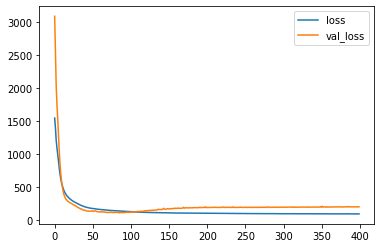

In [22]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

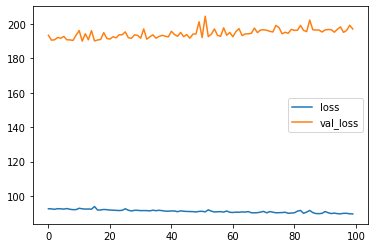

In [23]:
_ = plt.plot(history.history['loss'][-100:], label='loss')
_ = plt.plot(history.history['val_loss'][-100:], label='val_loss')
_ = plt.legend()
_ = plt.show()

Predictions made on the training set (for determining whether or not we overtraining 

There were 0 negative predictions
1-step MSE [Naive, NN model] = [120.41959446037183,89.28711130716171]
1-step R^2 [Naive, NN model] = [0.91597417503742,0.9377049861444116]


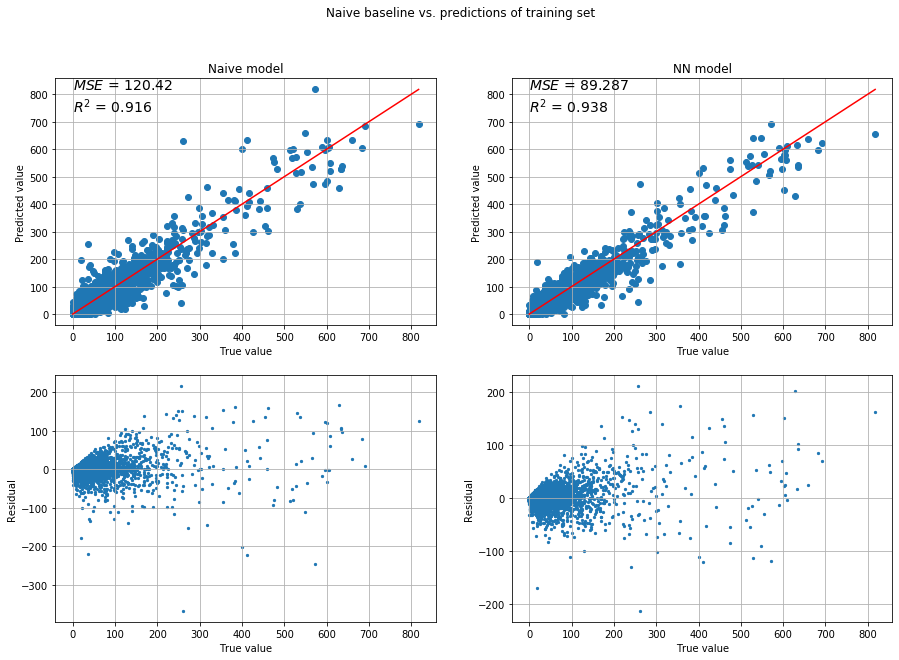

In [24]:
y_true = y_final_train.ravel()
y_naive = np.concatenate((y_train_naive, y_validate_naive),axis=0)
y_predict = best_nn.predict(X_final_train).ravel()
model_analysis(y_true, y_naive, y_predict, n_countries, title='NN model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='nn_training_performance.jpg')

Predictions made on the holdout set.

There were 0 negative predictions
1-step MSE [Naive, NN model] = [441.6371257671233,196.9700751792899]
1-step R^2 [Naive, NN model] = [0.8302251301912098,0.9244435126112523]


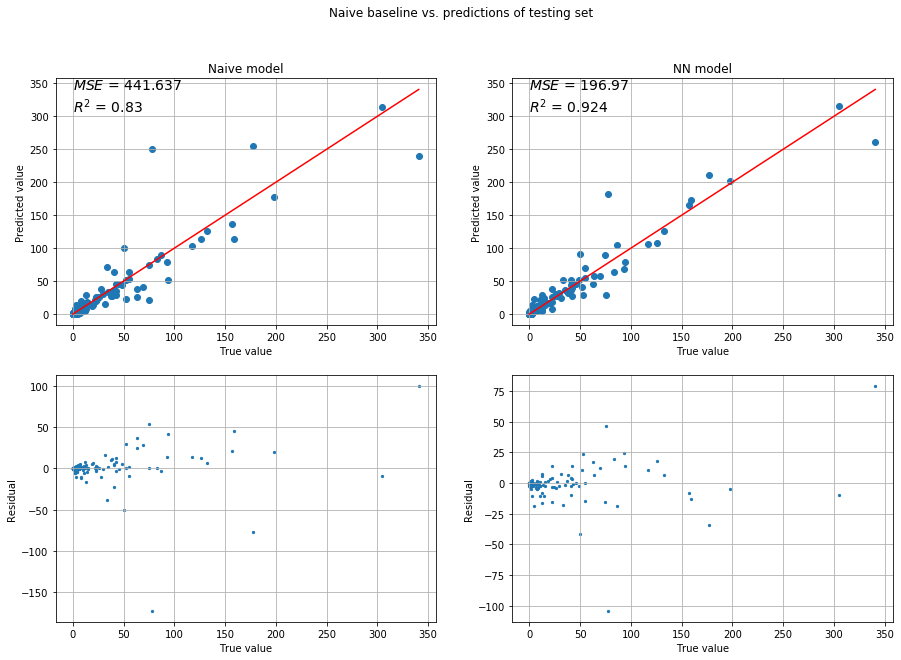

In [25]:
y_true = y_nn_test_model.ravel()
y_predict = best_nn.predict(X_nn_test_model).ravel()
model_analysis(y_true, y_test_naive, y_predict, n_countries, title='NN model',
               suptitle='Naive baseline vs. predictions of testing set',
              figname='nn_test_performance.jpg')

Look at the distribution of scores, with respect to epochs and shaded with respect ot first layer output dimension.

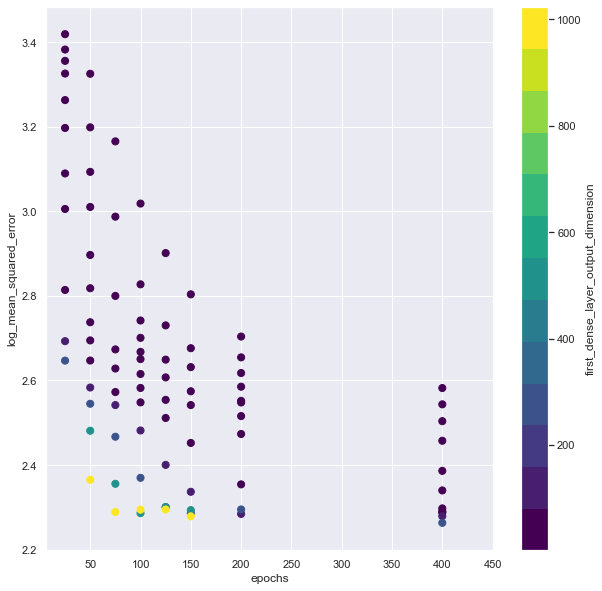

In [26]:
sns.set()
ncolors = all_scores.first_dense_layer_output_dimension.nunique()
all_scores.loc[:, 'log_mean_squared_error'] = all_scores.loc[:, 'mean_squared_error'].apply(lambda x : np.log10(x+1)).values

fig, ax = plt.subplots()
cax = all_scores.plot.scatter(x='epochs', y='log_mean_squared_error', 
                      c='first_dense_layer_output_dimension',
                      figsize=(10,10), 
                      ax=ax,
                      cmap=plt.cm.get_cmap('viridis', ncolors),
                             s=50)
loc,lab = plt.xticks()
_ = ax.set_xticks([int(l) for l in loc[1:]])
_ = ax.set_xticklabels([int(l) for l in loc[1:]])

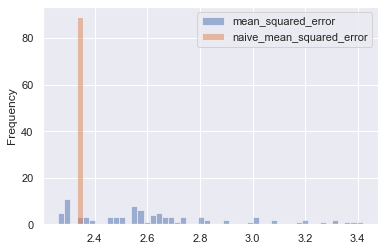

In [27]:
all_scores.loc[:,column_search(all_scores,'squared')].iloc[:,:2].apply(np.log10).plot.hist(alpha=0.5, bins=50)

Is there any commonality between the models that beat the naive baseline? For future work I believe it would be wrothwhile to investigate the potential relationship between output dimension and MSE. In other words, test my assumption that the number of parameters should be small. Some evidence I was wrong is found by looking at the subset of models which were able to beat the naive baseline. First, look at how many runs were made for each dimension value

In [28]:
all_scores.first_dense_layer_output_dimension.value_counts().sort_index()

2       8
4       8
6       5
8       8
12      5
16      8
24      5
32      8
64      8
128     8
256     8
512     5
1024    5
Name: first_dense_layer_output_dimension, dtype: int64

In [29]:
all_scores.iloc[:,:3]

,epochs,batch_size,first_dense_layer_output_dimension
0,25,1024,2
1,25,1024,4
2,25,1024,6
3,25,1024,8
4,25,1024,12
...,...,...,...
100,150,1024,64
101,150,1024,128
102,150,1024,256
103,150,1024,512


Then look at the value counts for the models that beat the baseline; it favors the models with higher dimensionality.

In [30]:
beat_baseline = all_scores[(all_scores.naive_mean_squared_error 
                            -all_scores.mean_squared_error) >0].sort_values(by='mean_squared_error')

beat_baseline.first_dense_layer_output_dimension.value_counts().sort_index()

16      1
24      1
32      1
64      1
128     3
256     4
512     3
1024    4
Name: first_dense_layer_output_dimension, dtype: int64

Going further, averaging with respect to first layer output dimension shows an inverse proportionality.

In [31]:
all_scores.groupby(['first_dense_layer_output_dimension']).mean()

,epochs,batch_size,mean_squared_error,mean_absolute_error,explained_variance,naive_mean_absolute_error,naive_explained_variance,naive_mean_squared_error,log_mean_squared_error
first_dense_layer_output_dimension,,,,,,,,,
2,140.625,1024.0,1195.050541,15.972101,0.602946,5.934804,0.926058,219.307632,2.989953
4,140.625,1024.0,930.326545,14.078497,0.689969,5.934804,0.926058,219.307632,2.875152
6,155.000,1024.0,957.981394,14.055592,0.680727,5.934804,0.926058,219.307632,2.862532
8,140.625,1024.0,726.623503,12.522694,0.757995,5.934804,0.926058,219.307632,2.770117
12,155.000,1024.0,736.358703,12.195855,0.754530,5.934804,0.926058,219.307632,2.753202
16,140.625,1024.0,561.974055,10.992945,0.812859,5.934804,0.926058,219.307632,2.676178
24,155.000,1024.0,541.345072,10.672853,0.819389,5.934804,0.926058,219.307632,2.649843
32,140.625,1024.0,438.170283,9.733656,0.853703,5.934804,0.926058,219.307632,2.596033
64,140.625,1024.0,355.908950,8.833541,0.881041,5.934804,0.926058,219.307632,2.524721


<a id='conclusion'></a>
# 5. Conclusion and future work
[Return to table of contents](#toc)

There are many different ideas I have for changes that can be made, both with respect to the model architectures as well as the data itself. Changing the size of the time frames, prediction intervals, data splits, subset of the data used, subset of countries used, changing the architecture, the scaling method, the parameters. I also do not want to forget to mention that the amount of data is increasing over time, as the pandemic continues.